# EDA on German Fake News Dataset

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
#from nltk.corpus import stopwords
from dotenv import load_dotenv
load_dotenv()


pd.set_option('display.max_rows', 100)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## Read data

In [2]:

NEWS_CSV = os.path.join(os.getenv('PROJECT_DIR'), 'data', 'raw', 'news.csv')
df = pd.read_csv(NEWS_CSV)
df.head()

,id,url,Titel,Body,Kategorie,Datum,Quelle,Fake,Art
0,773233,http://www.der-postillon.com/2018/01/grokoleak...,Exklusiv! Das geheime WhatsApp-Chat-Protokoll ...,Die Sondierungsgespräche zwischen Union und SP...,wirtschaft,2018-01-18 00:00:00,Postillion,1,NaN
1,773234,http://www.der-postillon.com/2018/01/trump-san...,"Trump droht, jeden zu verspeisen, der an seine...",Nun ist es auch medizinisch offiziell bestätig...,wirtschaft,2018-01-17 00:00:00,Postillion,1,NaN
2,773235,http://www.der-postillon.com/2018/01/fdp-sondi...,"Soli runter, keine Steuererhöhungen, kein Klim...","Es waren zähe Verhandlungen, doch die Freien D...",wirtschaft,2018-01-12 00:00:00,Postillion,1,NaN
3,773236,http://www.der-postillon.com/2018/01/joachim-s...,Hat sie eine Affäre? Joachim Sauer glaubt Ange...,Wo treibt sie sich immer bis spät in die Nacht...,wirtschaft,2018-01-09 00:00:00,Postillion,1,NaN
4,773237,http://www.der-postillon.com/2018/01/halb-so-s...,"""Er hat ja nur HALBneger gesagt"": So begründet...",Der Parteivorstand drückt nochmal ein Auge zu:...,wirtschaft,2018-01-08 00:00:00,Postillion,1,NaN


## Start exploring the data

In [3]:
print('Columns with missing values:')
print(df.isnull().sum())

Columns with missing values:
id               0
url              0
Titel            0
Body             0
Kategorie     1322
Datum            0
Quelle           0
Fake             0
Art          40972
dtype: int64


Kategorie und Art have missing values. Consider this if those columns should be used for modeling.
Now lets have a look on the "Fake" column. Assuming this will be the dependent variable for modeling...
### How does the distribution of fake news in this dataset look like?

In [4]:
df['Fake'].value_counts(normalize=True)

0    0.927554
1    0.072446
Name: Fake, dtype: float64

~ 7.2% of the instances are fake news. Consequently we have to deal with an unbalanced dataset. Keep that in mind for modeling and validation (proper metrics should be applied!).

### So where are the articles actually come from (source)?

In [5]:
df['Quelle'].value_counts()

Reuters        32984
Pressetext     22896
Kleine          3361
Postillion      2040
Einezeitung     1322
Tagespresse     1130
Zeitspiegel      135
Name: Quelle, dtype: int64

In [6]:
df.groupby('Quelle')['Fake'].sum()

Quelle
Einezeitung    1322
Kleine            0
Postillion     2040
Pressetext        0
Reuters           0
Tagespresse    1130
Zeitspiegel     135
Name: Fake, dtype: int64

Fake News are coming solely from 
* Einezeitung
* Postillion
* Tagespresse
* Zeitspiegel 

Obviously all these sources are considered as **satirical news** sites. So the publisher of this dataset treated those sarcastic news articles as fake. And yes, they are actually fake by intention. Such intentionally faked story are live from exaggerated expressions and inappropriate vocabulary compared to the context they appear in.

> Further analysis and model results on test data will show, if this kind of fake news is appropriate for training a model that should be capable of detecting fake news from non-sarcastic news articles.

In [7]:
# By the way: This is my my favourite one...
df[df['Quelle'] == 'Zeitspiegel']['Titel'][36154]

'Gesundheitscheck bestätigt: US-Präsident Donald Trump vollkommen gesundes und normales Arschloch'

Now let's have a look on the "Kategorie"...

In [8]:
df['Kategorie'].value_counts()

Weltnachrichten            9626
Unternehmensnachrichten    7968
BUSINESS                   6628
LEBEN                      6436
Inlandsnachrichten         5461
HIGHTECH                   4842
MEDIEN                     4598
Wirtschaftsnachrichten     4497
Top-Nachrichten            2884
Politik                    1836
Marktnachrichten           1669
wirtschaft                  938
International               731
Wirtschaft                  680
Österreich                  522
panorama                    495
Chronik                     483
ADHOC                       392
Sport                       352
Leute                       337
sport                       308
Kultur                      200
wissenschaft                129
eltnachrichten              128
nlandsnachrichten           116
medien                       85
leute                        85
irtschaftsnachrichten        41
nternehmensnachrichten       39
Wissen                       14
Panorama                     12
Gesundhe

In [9]:
df.groupby(['Quelle', 'Kategorie'])['Fake'].sum()

Quelle       Kategorie              
Kleine       International                0
             Kultur                       0
             Leute                        0
             Politik                      0
             Sport                        0
             Wirtschaft                   0
             Österreich                   0
Postillion   leute                       85
             medien                      85
             panorama                   495
             sport                      308
             wirtschaft                 938
             wissenschaft               129
Pressetext   ADHOC                        0
             BUSINESS                     0
             HIGHTECH                     0
             LEBEN                        0
             MEDIEN                       0
Reuters      Inlandsnachrichten           0
             Marktnachrichten             0
             Politik                      0
             Top-Nachrichten           

Some category names seems to be corrupted. So keep in mind we have to deal with them later on if we use "Kategorie" as feature in our model.

### How does the text look like?

First we check for duplicates in the dataset...

In [10]:
print(df.duplicated(subset=['Titel', 'Body']).value_counts(normalize=True))
df[df.duplicated(subset=['Titel', 'Body'])]

False    0.980444
True     0.019556
dtype: float64


,id,url,Titel,Body,Kategorie,Datum,Quelle,Fake,Art
2180,775488,https://de.reuters.com/article/deutschland-koa...,Kauder - An Sondierungs-Ergebnissen gibt es ni...,Unions-Fraktionschef Volker Kauder hat sich ge...,Inlandsnachrichten,2018-01-15 00:00:00,Reuters,0,NaN
2217,775525,https://de.reuters.com/article/deutschland-koa...,Kooperationsverbot in Bildungsfinanzierung sol...,Union und SPD wollen das Kooperationsverbot in...,Inlandsnachrichten,2018-01-12 00:00:00,Reuters,0,NaN
2301,775609,https://de.reuters.com/article/deutschland-koa...,Groko-Sondierer rütteln am Klimaschutzziel für...,"Die Sondierer von CDU, CSU und SPD haben bei F...",Top-Nachrichten,2018-01-08 00:00:00,Reuters,0,NaN
2351,775660,https://de.reuters.com/article/deutschland-eas...,Easyjet will Passagierzahl in Deutschland verd...,Der britische Billigflieger Easyjet will nach ...,Unternehmensnachrichten,2018-01-05 00:00:00,Reuters,0,NaN
2366,775675,https://de.reuters.com/article/usa-trump-idDEK...,Trump lässt nach Bruch mit Bannon die Anwälte los,US-Präsident Donald Trump versucht seinen Ex-C...,Weltnachrichten,2018-01-05 00:00:00,Reuters,0,NaN
...,...,...,...,...,...,...,...,...,...
63859,838140,http://www.kleinezeitung.at//leute/5367537/Sta...,62. Opernball: Das ist die Gästeliste,Die Übertragung des Balles im Fernsehen dürfte...,Leute,2018-02-07 00:00:00,Kleine,0,NaN
63860,838141,http://www.kleinezeitung.at//leute/5367585/Ver...,Guido Maria Kretschmer freut sich auf Hochzeit,Kretschmer und der zehn Jahre ältere Mutters l...,Leute,2018-02-07 00:00:00,Kleine,0,NaN
63861,838142,http://www.kleinezeitung.at//leute/5367456/Ers...,Kylie Jenner verriet den Namen ihrer Tochter,"Der Vorname ""Stormi"" kam bei ihren Fans gut an...",Leute,2018-02-07 00:00:00,Kleine,0,NaN
63862,838143,http://www.kleinezeitung.at//kaernten/5378399/...,Verendete Kühe auf Hof: Staatsanwaltschaft prü...,Schwere Vorwürfe gegen Landwirt aus Hüttenberg...,Österreich,2018-02-26 00:00:00,Kleine,0,NaN


In [11]:
# We drop them...
df = df.drop_duplicates(subset=['Titel', 'Body']).reset_index()

Now lets have a quick look at how many words and characters we have in Titel and Body? 

In [12]:
# Count for max character and word length in Titel and Body
print('Max # of char in Title: %i' % df['Titel'].str.len().max())
cnt_lst = []
for i in range(0, len(df)):
    cnt_lst.append(len(df['Titel'][i].split()))
print('Max # words in Title: %i' % max(cnt_lst))
print('Average # of words in Title: %i' % np.mean(cnt_lst))

print('Max char length of Body: %i' % df['Body'].str.len().max())
cnt_lst = []
for i in range(0, len(df)):
    cnt_lst.append(len(df['Body'][i].split()))
print('Max # of words in Body: %i' % max(cnt_lst))
print('Average # of words in Body: %i' % np.mean(cnt_lst))

Max # of char in Title: 431
Max # words in Title: 48
Average # of words in Title: 6
Max char length of Body: 10032
Max # of words in Body: 1455
Average # of words in Body: 336


Ok, this seams to be quite reasonable for news articles.

### From what year they actually stem from?

<AxesSubplot:ylabel='Frequency'>

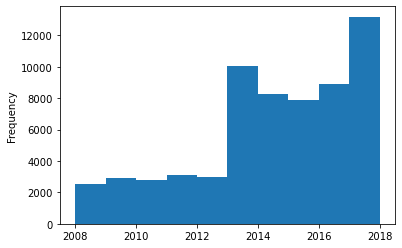

In [13]:
df['Datum'] = pd.to_datetime(df['Datum'])
df['Jahr'] = df['Datum'].apply(lambda x: x.year)
df['Jahr'].plot(kind = 'hist')

Ok, so the majority of articles were published from 2013 to 2018. We are in 2021 as this EDA was perfromed. So the latest articles are already 3 years old. Could that have an implication on our model we want to train?
* Topics (and therefore the vocabulary) in the train data could be outdated? (e.g. Nobody talked about covid-19 in 2018!)

## Preprocessing and preparing text features

We already know (and expected) from a first look on the text features, that they contain a lot of stopwords. Therefore we take a stopword list from nltk.

Afterwards we ceate a word count matrix with CountVectorizer Object from scikit-learn and play around a bit...

In [14]:
# Init a stopword list from nltk and use it as arg in CountVectorizer...
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('german')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dominikl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Count Vec Titel...

In [15]:
count_vec_titel = CountVectorizer(stop_words=stopword_list,
                                  token_pattern=r'\b[a-zA-Z]{2,}\b',
                                  max_features=50)
                                  #ngram_range=(2,2)
                                #)
# We first do that on Titel...
count_vec_titel.fit(df['Titel'])
word_counts_in_titel = count_vec_titel.transform(df['Titel']).todense()

### What are the most occuring words?

In [16]:
df_titel = pd.DataFrame(word_counts_in_titel, columns=count_vec_titel.get_feature_names())
df_titel.head()

,ab,ag,bank,banken,brexit,chef,china,dax,deutsche,deutschland,...,trotz,trump,ukraine,un,us,usa,vw,warnt,wegen,wirtschaft
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_titel_trans = pd.DataFrame(df_titel.T.sum(axis=1), columns=['count'])

In [18]:
df_titel_trans.sort_values(by='count', ascending=False).head(50)

,count
us,2191
eu,1788
deutsche,1425
mehr,1371
usa,1267
euro,1185
neue,1175
ab,1149
merkel,1030
deutschland,1016


Now count vec the body...

In [19]:
count_vec_body = CountVectorizer(stop_words=stopword_list,
                                  token_pattern=r'\b[a-zA-Z]{2,}\b',
                                  max_features=50,
                                  #ngram_range=(2,2)
                                )
count_vec_body.fit(df['Body'])
word_counts_in_body = count_vec_body.transform(df['Body']).todense()

In [20]:
df_body = pd.DataFrame(word_counts_in_body, columns=count_vec_body.get_feature_names())
df_body.head()

,ab,allerdings,beim,bereits,com,dabei,de,deutschen,deutschland,dollar,...,viele,wegen,weitere,worden,wurde,wurden,www,zudem,zufolge,zwei
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,1,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_body_trans = pd.DataFrame(df_body.T.sum(axis=1), columns=['count'])
df_body_trans.sort_values(by='count', ascending=False).head(20)

,count
prozent,81511
sagte,54035
mehr,51646
euro,51302
http,46753
sei,41417
seit,30498
us,30249
unternehmen,29656
www,28723
